# 11. Online Classification

*Made by David Serrano for his Final Bachelor Thesis*

This file analysis a track using the online system.

## 11.1. Environment preparation

In [ ]:
# Useful general imports
from google.colab import drive

In [ ]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [ ]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

## 11.2. Analysis

In [ ]:
EXAMPLE_FILE = '20181004.046_AEQ50'
TRACKID = 47

In [ ]:
from JSONLoader import loadData
from hdf5Loader import hdf5Loader

#detections = loadData(PROJECT_ROOT + '/data/experiment/' + EXAMPLE_FILE + 'pred.h5.json')
detections = loadData(JSON_FOLDER + EXAMPLE_FILE + '.h5.json')

loader = hdf5Loader(HDF5_FOLDER + EXAMPLE_FILE + '.h5')

HSdetections = []
[HSdetections.append(d) for d in detections if d[1]==TRACKID]

print('The track is a HotSpot')
print(len(HSdetections))

The track is a HotSpot
427


In [ ]:
modelName = 'ResNet50_epoch5_dataAugPixRange5.pt'

In [ ]:
from torchvision.models import resnet50
import torch.nn as nn
import torch
from dataPrep import crop_detection
from tqdm.notebook import tqdm
import numpy as np

# Load the model
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128,3)
)

model.load_state_dict(torch.load(PROJECT_ROOT + '/models/' + modelName,
                                    map_location=torch.device('cpu')))

# Delete the final two layers of the model (ReLU and Linnear(128,3))
model.fc = nn.Sequential(*[model.fc[0]])
print('The fully connected layer of the model is:\n', model.fc)

images = []
# Load all the images 
for idx, frameNumber in enumerate(range(HSdetections[0][0], HSdetections[-1][0] + 1)):
    image = crop_detection(loader.loadImage(frameNumber),
                                 [HSdetections[idx][2], HSdetections[idx][3],
                                  HSdetections[idx][4], HSdetections[idx][5]])
    image = np.stack((image,)*3, axis=-1)
    image = np.moveaxis(image, -1, 0)
    image = ((1/4095) * image).astype(np.float16)
    image = torch.Tensor(image)
    image = torch.unsqueeze(image, 0)

    images.append(image)

The fully connected layer of the model is:
 Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

def normalizeData(X, scaler='Standard', range=(0,1)):
    """
    Function to scale features with different parameters
    :param X: feature matrix
    :param scaler: type of scaler ('Standard', 'MaxAbs', 'MinMax')
    :return X_norm: feature matrix normalized
    """

    X_norm = []

    if scaler=='Standard':
        print('Scaling each feature by removing the mean and scaling to unit variance')
        scaler = StandardScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MaxAbs':
        print('Scaling each feature by its maximum absoulute value.')
        scaler = MaxAbsScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MinMax':
        print('Normalizing the input data such that the min and max value are', range)
        scaler = MinMaxScaler(feature_range=range)
        scaler.fit(X)
        X_norm = scaler.transform(X)
        
    return X_norm

In [ ]:
from online import onlineClassification
from sklearn.externals import joblib

XGBoost = joblib.load(PROJECT_ROOT + '/models/XGBoostClass.pkl')

predictions = onlineClassification(network=model, classifier=XGBoost, images=images, n=5)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Frame: 5 - 0
Frame: 6 - 0
Frame: 7 - 0
Frame: 8 - 0
Frame: 9 - 0
Frame: 10 - 0
Frame: 11 - 0
Frame: 12 - 0
Frame: 13 - 0
Frame: 14 - 0
Frame: 15 - 0
Frame: 16 - 0
Frame: 17 - 0
Frame: 18 - 0
Frame: 19 - 0
Frame: 20 - 0
Frame: 21 - 0
Frame: 22 - 0
Frame: 23 - 0
Frame: 24 - 0
Frame: 25 - 0
Frame: 26 - 0
Frame: 27 - 0
Frame: 28 - 0
Frame: 29 - 0
Frame: 30 - 0
Frame: 31 - 0
Frame: 32 - 0
Frame: 33 - 0
Frame: 34 - 0
Frame: 35 - 0
Frame: 36 - 0
Frame: 37 - 0
Frame: 38 - 0
Frame: 39 - 0
Frame: 40 - 0
Frame: 41 - 0
Frame: 42 - 0
Frame: 43 - 0
Frame: 44 - 0
Frame: 45 - 0
Frame: 46 - 0
Frame: 47 - 0
Frame: 48 - 0
Frame: 49 - 0
Frame: 50 - 0
Frame: 51 - 0
Frame: 52 - 0
Frame: 53 - 0
Frame: 54 - 0
Frame: 55 - 0
Frame: 56 - 0
Frame: 57 - 0
Frame: 58 - 0
Frame: 59 - 0
Frame: 60 - 0
Frame: 61 - 0
Frame: 62 - 0
Frame: 63 - 0
Frame: 64 - 0
Frame: 65 - 0
Frame: 66 - 0
Frame: 67 - 0
Frame: 68 - 0
Frame: 69 - 0
Frame: 70 - 0
Frame: 71 - 0
Frame: 72 - 0
Frame: 73 - 0
Frame: 74 - 0
Frame: 75 - 0
Frame: 76 -

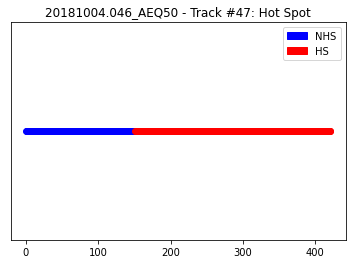

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

for idx, prediction in enumerate(predictions):
    if prediction == 0:
        plt.scatter(idx, 0, c='b')
    else:
        plt.scatter(idx, 0, c='r') 

plt.title('{} - Track #{}: Hot Spot'.format(EXAMPLE_FILE, TRACKID))
_ = plt.gca().axes.get_yaxis().set_ticks([])

blue_patch = mpatches.Patch(color='b', label='NHS')
red_patch = mpatches.Patch(color='r', label='HS')

plt.legend(handles=[blue_patch, red_patch])
plt.show()